# Set up LightGBM on GPU

In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM


rm: cannot remove '/opt/conda/lib/python3.6/site-packages/lightgbm': No such file or directory
Cloning into 'LightGBM'...
remote: Enumerating objects: 18188, done.
remote: Total 18188 (delta 0), reused 0 (delta 0), pack-reused 18188
Receiving objects: 100% (18188/18188), 12.06 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (13254/13254), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [ ]:
# %%bash
# cd LightGBM
# mkdir build ; cd build
# cmake ..
# make -j4

In [ ]:
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)


-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

rm: cannot remove 'build': No such file or directory


In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading man

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

# Running Model

In [39]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

In [40]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [41]:
pd.options.display.max_columns = 50

In [42]:
VERSION=15

# Load datasets

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
data_dir = "/content/drive/My Drive/M5/Data/"
calendar = pd.read_csv(data_dir+'calendar.csv')
calendar = reduce_mem_usage(calendar)
print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))

sell_prices = pd.read_csv(data_dir+'sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)
print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))

sales = pd.read_csv(data_dir+'sales_train_evaluation.csv')
print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns


In [49]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [45]:
idCols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
product = sales[idCols].drop_duplicates()

In [46]:
import warnings
warnings.filterwarnings('ignore')

submission = pd.read_csv(data_dir+'sample_submission.csv')
validate_submission = submission[submission.id.str.endswith('validation')]
eval_submission = submission[submission.id.str.endswith('evaluation')]

# change column name
newcolumns = ["id"] + ["d_{}".format(i) for i in range(1914, 1914+28)]
validate_submission.columns = newcolumns
validate_submission['id'] = validate_submission['id'].str.replace('_validation', "_evaluation")
validate_submission = validate_submission.merge(product, how = 'left', on = 'id')

newcolumns = ["id"] + ["d_{}".format(i) for i in range(1942, 1942+28)]
eval_submission.columns = newcolumns
eval_submission = eval_submission.merge(product, how = 'left', on = 'id')


In [50]:
idCols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Use only the last three years
DAYS = int(365*3); LAST_DAY=1941
dayCols = ["d_{}".format(i) for i in range(LAST_DAY-DAYS+1, LAST_DAY+1)]
print(len(dayCols), dayCols[0])
sales = sales[idCols+dayCols]
print(sales.shape)
sales.head()

1095 d_847
(30490, 1101)


,id,item_id,dept_id,cat_id,store_id,state_id,d_847,d_848,d_849,d_850,d_851,d_852,d_853,d_854,d_855,d_856,d_857,d_858,d_859,d_860,d_861,d_862,d_863,d_864,d_865,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,2,1,3,1,0,0,0,3,6,4,0,0,1,1,2,0,0,1,1,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,3,1,0,0,0,0,0,0,0,0,0,1,0,2,1,2,1,1,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [51]:
def melted(df, name=""):
    df = pd.melt(df, id_vars = idCols, var_name = 'day', value_name = 'demand')
    print('{}: {} rows and {} columns'.format(name, df.shape[0], df.shape[1]))
    df = reduce_mem_usage(df)
    # df.to_csv(name+".csv")
    return df

melted_sales = melted(sales)
melted_sales["part"] = "train"

melted_validate = melted(validate_submission)
melted_validate["part"] = "validate"

melted_eval = melted(eval_submission)
melted_eval["part"] = "evaluate"

: 33386550 rows and 8 columns
Mem. usage decreased to 1846.71 Mb (9.4% reduction)
: 853720 rows and 8 columns
Mem. usage decreased to 46.41 Mb (10.9% reduction)
: 853720 rows and 8 columns
Mem. usage decreased to 46.41 Mb (10.9% reduction)


In [17]:
# data = melted_sales
data = pd.concat([melted_sales, melted_validate, melted_eval], axis = 0)
# data = pd.concat([melted_sales, melted_validate], axis = 0)
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,0,train
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,0,train
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,0,train
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,1,train
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,0,train


In [18]:
import gc
del melted_sales, melted_validate
del submission, validate_submission, eval_submission, product
del sales,
gc.collect()

814

In [19]:
# merge with calendar, sell_prices

calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

print('Our dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# get the sell price data (this feature should be very important)
# version 12: left join sell_prices
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))


Our dataset to train has 23965140 rows and 17 columns
Our final dataset to train has 23965140 rows and 18 columns


In [20]:
del calendar, sell_prices
gc.collect()

0

In [21]:
na_sell_price = data["sell_price"].isnull().sum()/len(data) #= df[['a','b']].fillna(value=0)
print("Sell price NA: ", na_sell_price*100, "%")

data["sell_price"] = data["sell_price"].fillna(value=0)

Sell price NA:  5.738652058782048 %


# Feature Engineering

In [22]:
from sklearn import preprocessing
def encode_categorical(dt, cols):
    for col in cols:
        # Leave NaN as it is.
#         le = preprocessing.LabelEncoder()
#         not_null = df[col][df[col].notnull()]
#         df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)
        
#         np.save(f'label_class_{col}.npy', le.classes_)
        dt[col] = dt[col].astype("category").cat.codes.astype("int16")
        dt[col] -= dt[col].min()
    return dt


data = encode_categorical(data, ["cat_id", "dept_id", "item_id", "state_id", "store_id"]).pipe(reduce_mem_usage)
values = {'event_name_1': "normal", 'event_type_1': "normal", "event_name_2": "normal", 'event_type_2': "normal"}
data.fillna(value=values, inplace = True);

data = encode_categorical(data, ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]).pipe(reduce_mem_usage)

Mem. usage decreased to 1805.54 Mb (4.8% reduction)
Mem. usage decreased to 1165.60 Mb (7.3% reduction)


In [23]:
def datetime_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    attrs = [
        "year", 
        "quarter", 
        "month", 
        "week", 
        "day", 
        "dayofweek", 
        "weekday",
        "weekofyear",
#         "is_year_end", 
#         "is_year_start", 
#         "is_quarter_end", 
#         "is_quarter_start", 
#         "is_month_end",
#         "is_month_start",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df['date'].dt, attr).astype(dtype)
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    
    return df

data = datetime_features(data)
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,year,quarter,month,week,day,dayofweek,weekday,weekofyear,is_weekend
0,HOBBIES_1_001_CA_1_evaluation,1438,4,2,1,1,0,train,2014-04-26,11413,30,4,1,1,0,0,0,8.257812,2014,2,4,17,26,5,5,17,1
1,HOBBIES_1_002_CA_1_evaluation,1439,4,2,1,1,0,train,2014-04-26,11413,30,4,1,1,0,0,0,3.970703,2014,2,4,17,26,5,5,17,1
2,HOBBIES_1_003_CA_1_evaluation,1440,4,2,1,1,0,train,2014-04-26,11413,30,4,1,1,0,0,0,2.970703,2014,2,4,17,26,5,5,17,1
3,HOBBIES_1_004_CA_1_evaluation,1441,4,2,1,1,1,train,2014-04-26,11413,30,4,1,1,0,0,0,4.640625,2014,2,4,17,26,5,5,17,1
4,HOBBIES_1_005_CA_1_evaluation,1442,4,2,1,1,0,train,2014-04-26,11413,30,4,1,1,0,0,0,3.080078,2014,2,4,17,26,5,5,17,1


In [24]:
data.sort_values(by=['id', "date"], inplace=True)

X_train = data[data["part"]=="train"]
X_val = data[data["part"]=="validate"]
X_eval = data[data["part"]=="evaluate"]

print(len(X_train), len(X_val), len(X_eval))
del data; gc.collect()

22257700 853720 853720


0

In [25]:
X_train.shape, X_train.columns

((22257700, 27),
 Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand',
        'part', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1',
        'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
        'sell_price', 'year', 'quarter', 'month', 'week', 'day', 'dayofweek',
        'weekday', 'weekofyear', 'is_weekend'],
       dtype='object'))

In [29]:
import pickle 
dbfile = open(data_dir+f'../modeld2d/X_train.pkl', 'wb') 
pickle.dump(X_train, dbfile)
dbfile.close() #Dont forget this 

dbfile = open(data_dir+f'../modeld2d/X_val.pkl', 'wb') 
pickle.dump(X_val, dbfile)
dbfile.close() #Dont forget this 

dbfile = open(data_dir+f'../modeld2d/X_eval.pkl', 'wb') 
pickle.dump(X_eval, dbfile)
dbfile.close() #Dont forget this 

In [30]:
# del X_train, X_val; 
gc.collect()

464

In [31]:
import math

def numerical_feature(df, lag=[7, 28], rd=True):
    for i in lag:
        df[f"shifted_t{i}"] = df[["id","demand"]].groupby('id')["demand"].shift(i)

    ll = lag[2:] if rd else lag
    for i in ll:
      col = f"shifted_t{i}"
      for win in [7, 28]:
          df[f"rolling_mean_{col}_w{win}"] = df[["id", col]].groupby('id')[col].shift(1).rolling(win, min_periods=1).mean()

    return df



# Train Model

In [ ]:
# version 8.0: use poisson
# params = {
#         "objective" : "poisson",
#         "metric" :"rmse",
#         "force_row_wise" : True,
#         "learning_rate" : 0.075,
# #         "sub_feature" : 0.8,
#         "sub_row" : 0.75,
#         "bagging_freq" : 1,
#         "lambda_l2" : 0.1,
# #         "nthread" : 4
#         "metric": ["rmse"],
#     'verbosity': 1,
#     'num_iterations' : 3000,
#     'num_leaves': 128,
#     "min_data_in_leaf": 100,
#     'device': 'gpu',
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0
# }

# version 11.0: use tweedie
params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 3000,
    'num_leaves': 128,
    "min_data_in_leaf": 104,
    # 'device': 'gpu',
    # 'gpu_platform_id': 0,
    # 'gpu_device_id': 0
}


In [ ]:
import pickle
def load_X(train=True):
  if train:
    filename = data_dir+f'X_train.pkl'
  else:
    filename = data_dir+f'X_val.pkl'

  with open(filename, 'rb') as fin:
      X = pickle.load(fin)
  return X

# X_train = load_X(train=True)
# print(X_train.shape, "NDATE:", len(X_train["date"].unique()))
# X_train.head()

In [ ]:
X_train = load_X(train=True)
X_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,year,quarter,month,week,day,dayofweek,weekday,weekofyear,is_weekend
1612,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,train,2014-04-26,11413,30,4,1,1,0,0,0,2.240234,2014,2,4,17,26,5,5,17,1
32102,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,train,2014-04-27,11413,30,4,1,1,0,0,0,2.240234,2014,2,4,17,27,6,6,17,1
62592,FOODS_1_001_CA_1_validation,0,0,0,0,0,1,train,2014-04-28,11413,30,4,1,1,0,0,0,2.240234,2014,2,4,18,28,0,0,18,0
93082,FOODS_1_001_CA_1_validation,0,0,0,0,0,1,train,2014-04-29,11413,30,4,1,1,0,0,0,2.240234,2014,2,4,18,29,1,1,18,0
123572,FOODS_1_001_CA_1_validation,0,0,0,0,0,1,train,2014-04-30,11413,30,4,1,1,0,0,0,2.240234,2014,2,4,18,30,2,2,18,0


In [ ]:
X_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand',
       'part', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'year', 'quarter', 'month', 'week', 'day', 'dayofweek',
       'weekday', 'weekofyear', 'is_weekend'],
      dtype='object')

In [37]:
import pickle 
from sklearn.model_selection import train_test_split

np.random.seed(777)

cat_feats = []
cat_feats = cat_feats + ['item_id', 'dept_id','cat_id', 'store_id', 'state_id']
cat_feats = cat_feats + ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
cat_feats = cat_feats + ["snap_CA", "snap_TX", "snap_WI"]
cat_feats = cat_feats + ["year", "quarter", "month", "week", "day", "dayofweek", "weekofyear", "is_weekend"]

useless_cols = ["id", "part", "date", "demand","d", "wm_yr_wk", "weekday"]
def get_numberic_feature_col(d):
  lag = [1, 2, 7, 28]
  lag = [l+d for l in lag]
  shifted_col = [f"shifted_t{i}" for i in lag]
  rolling_col = []
  for i in lag[2:]:
    col = f"shifted_t{i}"
    rolling_col = rolling_col + [f"rolling_mean_{col}_w{win}" for win in [7, 28]]

  return shifted_col+rolling_col

def train_model(D, d=0):
  lag = [1, 2, 7, 28]
  offset_lag = [l+d for l in lag]
  data = numerical_feature(D, lag=offset_lag)

  for col in cat_feats:
    D[col] = D[col].astype('category')
    
  train_cols = list(data.columns[~data.columns.isin(useless_cols)].values)
  data.dropna(inplace = True)
  Y = data["demand"]
  X = data[train_cols]
  del D, data; gc.collect()

  # shitfed = list(filter(lambda col: col.startswith("shifted_"), (X.columns)))
  # display(data[["demand"]+shitfed].head(10))
  X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.05)
  train_set = lgb.Dataset(X, Y)
  test_set = lgb.Dataset(x_test, y_test)

  # train_set.set_feature_name(train_cols)
  # test_set.set_feature_name(train_cols)

  # train_set.set_categorical_feature(cat_feats)
  # test_set.set_categorical_feature(cat_feats)

  del X, Y, x_test, y_test; gc.collect()

  # train_set.save_binary(data_dir+f'train_set_{d}.bin')
  # test_set.save_binary(data_dir+f'test_set_{d}.bin')

  # return train_set, test_set

  print("Training...")
  # model = lgb.train(params, train_set, num_boost_round = 3000, early_stopping_rounds = 500, valid_sets = [train_set, test_set], verbose_eval = 100)
  model = lgb.train(params, train_set, valid_sets = [test_set], verbose_eval = 100)
  # model.save_model(data_dir+f"/Models/model_d{d}_v{VERSION}.lgb")

  dbfile = open(data_dir+f'/Models/D2D_d{d}v{VERSION}.pkl', 'wb') 
  pickle.dump(model, dbfile)
  dbfile.close() #Dont forget this 

  return model


# def train_model(d, train_set, test_set):
#   num_feature = get_numberic_feature_col(d)
  
#   # if train_set is None:
#   #   train_set = lgb.Dataset(data_dir+f'train_set_{d}.bin', feature_name=cat_feats+num_feature, categorical_feature=cat_feats)
  
#   # if test_set is None:
#   #   test_set = lgb.Dataset(data_dir+f'test_set_{d}.bin', feature_name=cat_feats+num_feature, categorical_feature=cat_feats)

#   print("Training...")
#   # model = lgb.train(params, train_set, num_boost_round = 3000, early_stopping_rounds = 500, valid_sets = [train_set, test_set], verbose_eval = 100)
#   model = lgb.train(params, train_set, valid_sets = [test_set], verbose_eval = 100)
#   # model.save_model(data_dir+f"/Models/model_d{d}_v{VERSION}.lgb")

#   dbfile = open(data_dir+f'/Models/D2D_d{d}v{VERSION}.pkl', 'wb') 
#   pickle.dump(model, dbfile)
#   dbfile.close() #Dont forget this 

#   return model


In [ ]:
%%time
# X_train = load_X(train=True)

# models = []
for i in [9]:
  print(f"========== Train {i} =======")
  try:
    D = load_X(train=True)
    m = train_model(D, d=i)
    print("DONE")
  except Exception as e:
    print(e)

  # break
  # models.append(m)

========== Train 9 =======


In [ ]:
# X_train.head()

# Predict

In [32]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

In [33]:
import pickle
data_dir = "/content/drive/My Drive/M5/"
VERSION=14
def load_models():
  models = []
  for i in range(28):
    filename = data_dir+f'ModelsV14/D2D_d{i}v14.pkl'
    
    print(filename)
    with open(filename, 'rb') as fin:
      m = pickle.load(fin)
      models.append(m)
  return models

models = load_models()

/content/drive/My Drive/M5/ModelsV14/D2D_d0v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d1v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d2v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d3v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d4v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d5v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d6v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d7v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d8v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d9v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d10v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d11v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d12v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d13v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d14v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d15v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d16v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d17v14.pkl
/content/drive/My Drive/M5/ModelsV14/D2D_d18v14.pkl
/content/drive/My Driv

In [34]:
X_train = load_X(train=True)
lastdate = X_train["date"].max() - pd.DateOffset(days=86)
X_train = X_train[X_train['date'] >= lastdate]

######
X_val = load_X(train=False)


In [35]:
models[0].feature_name()

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'year',
 'quarter',
 'month',
 'week',
 'day',
 'dayofweek',
 'weekofyear',
 'is_weekend',
 'shifted_t1',
 'shifted_t2',
 'shifted_t7',
 'shifted_t28',
 'rolling_mean_shifted_t1_w7',
 'rolling_mean_shifted_t1_w28',
 'rolling_mean_shifted_t2_w7',
 'rolling_mean_shifted_t2_w28',
 'rolling_mean_shifted_t7_w7',
 'rolling_mean_shifted_t7_w28',
 'rolling_mean_shifted_t28_w7',
 'rolling_mean_shifted_t28_w28']

In [38]:
%%time

import time

import datetime
import dateutil.relativedelta

def predict(models, X_train, X_test):
    DATES = X_test["date"].unique()
    NDATE = len(DATES)
    print("NDATE", NDATE)
    
    
    
    train = X_train
    test = X_test

    ids = test["id"].unique()        
    oarr = np.zeros((len(ids), NDATE+1))

    col = ["id"] + ["F{}".format(i) for i in range(1, NDATE+1)]
    o = pd.DataFrame(oarr, columns=col)
    o["id"] = test[test["date"]==DATES[0]]["id"].values

#     acc_o = []
#     itemId = sorted(itemId)
#     for iid in itemId:
#         test = X_test[X_test["dept_id"]==iid]
#         train = X_train[X_train["dept_id"]==iid]
        
#         ## XX=test, X=train
#         lastmonth = pd.to_datetime(train.head(1)["date"])

    

    for idx, date in enumerate(DATES):
        newrow = test[test["date"]==date]
        
        train = train.append(newrow)
        train.sort_values(by=['id', "date"], inplace=True)
# # #             print("num feats START")

        lag = [1, 2, 7, 28]
        offset_lag = [l+idx for l in lag]
        
        feat = numerical_feature(train.copy(), lag=offset_lag)

        train_cols = feat.columns[~feat.columns.isin(useless_cols)]          
# # #             print("num feats DONE")
        # print(train_cols)

        print(f"============== {idx} ==========")
# #             p = feat[feat["id"]=="FOODS_1_001_CA_1_validation"]
# # #             print(p)
# #             print(p.tail(15)[["date", "demand", "shifted_t7"]])
# #             if idx==10:
# #                 return None
          
        x = feat.loc[feat["date"] == date , train_cols]
        m = models[idx]
        for col in cat_feats:
          x[col] = x[col].astype('category')
      
        # print(len(x.columns), x.columns) 
        # print(len(m.feature_name()), m.feature_name())
        try:
          val_pred = m.predict(x, num_iteration=m.best_iteration)
        except Exception as e:
          val_pred = 0
          print("IDX", idx, e)
          
        o[f"F{idx+1}"] = val_pred
        # break
    return o

pred = predict(models, X_train, X_val)
pred.head()

NDATE 28
============== 0 ==========
IDX 0 train and valid dataset categorical_feature do not match.
============== 1 ==========
IDX 1 train and valid dataset categorical_feature do not match.
============== 2 ==========
IDX 2 train and valid dataset categorical_feature do not match.
============== 3 ==========
IDX 3 train and valid dataset categorical_feature do not match.
============== 4 ==========
IDX 4 train and valid dataset categorical_feature do not match.


KeyboardInterrupt: ignored

In [ ]:
# models

In [ ]:
pred.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.943307,0.617644,0.873431,0.901943,0.932832,1.287434,1.303396,0.891662,0.843088,0.671295,0.698080,0.679035,1.094759,0.965261,0.917368,0.833431,0.944742,0.771145,0.851183,1.200035,1.046747,0.680569,0.731131,0.710425,0.622239,0.737707,0.880924,0.704348
1,FOODS_1_001_CA_2_validation,0.947890,0.748746,1.088942,0.855606,1.100605,1.470718,1.331967,0.956745,0.818239,0.670796,0.906011,0.758923,1.001355,0.942815,0.864368,0.652201,1.010981,0.875820,0.819211,1.283540,1.079149,0.486875,0.614932,0.753515,0.633481,0.665310,0.807920,0.933307
2,FOODS_1_001_CA_3_validation,0.995876,0.574962,0.810865,0.779721,0.769330,1.154421,1.116919,0.744300,0.770171,0.827233,0.578851,0.745708,0.663068,0.729533,0.986496,0.795131,0.814339,0.803644,0.887321,0.920203,0.756383,0.569651,0.710589,0.689879,0.510861,0.578629,0.605130,0.938796
3,FOODS_1_001_CA_4_validation,0.442158,0.307089,0.363963,0.452349,0.377377,0.367811,0.364176,0.506673,0.401451,0.405576,0.488741,0.299325,0.536492,0.533980,0.530104,0.475224,0.627558,0.419071,0.447283,0.650335,0.608710,0.353497,0.433124,0.384561,0.321493,0.374809,0.414598,0.331847
4,FOODS_1_001_TX_1_validation,0.125668,0.059535,0.167973,0.139091,0.135822,0.172140,0.197456,0.159346,0.211217,0.165292,0.178290,0.187412,0.226787,0.226854,0.280709,0.250633,0.346222,0.261438,0.320181,0.348869,0.383882,0.197228,0.246566,0.217063,0.194498,0.218097,0.244120,0.235556


In [ ]:
submission = pd.read_csv(data_dir+'sample_submission.csv')
dfeval = submission[submission.id.str.endswith('evaluation')]


In [ ]:
VERSION=15
def save_csv(i, d):
    df = pd.concat([d, dfeval]) 

    df.sort_values("id", inplace = True)
    df.reset_index(drop=True, inplace = True)
    df.to_csv(data_dir+f"submission.v{VERSION}.{i}.csv")
    
save_csv("", pred)

# Evaluate

In [ ]:
best = pd.read_csv(data_dir+'submission.v8.csv')
best = best[best.id.str.endswith('validation')]

In [ ]:
best.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
1,FOODS_1_001_CA_1_validation,0.948686,0.908288,0.918677,0.849934,1.145563,1.298069,1.082863,1.047707,0.965313,1.026154,1.073706,1.123653,1.317306,1.163538,1.078745,0.987566,1.013287,1.000734,1.127123,1.390267,1.250577,1.001713,0.924763,0.932755,0.913453,1.127719,1.328388,1.274308
3,FOODS_1_001_CA_2_validation,0.996852,1.060056,1.105459,1.382280,1.329477,1.594912,2.258423,1.090894,1.023134,1.038965,1.159158,1.265910,1.668735,1.512311,1.176897,1.179362,1.178225,1.147058,1.399191,1.837019,1.749167,1.142625,1.111452,1.133505,1.193081,1.293758,1.703385,1.832835
5,FOODS_1_001_CA_3_validation,1.038830,1.016053,0.969064,0.961218,1.036430,1.251097,1.077721,0.944517,0.949785,0.990782,1.062121,1.074984,1.389883,1.247357,1.099748,1.077822,1.088579,1.097141,1.184089,1.412401,1.379840,1.036755,0.992780,1.014710,1.023227,1.088864,1.311497,1.189571
7,FOODS_1_001_CA_4_validation,0.456707,0.374663,0.374128,0.380191,0.496494,0.521518,0.517755,0.500455,0.432493,0.465029,0.520195,0.465405,0.476070,0.469835,0.421658,0.410800,0.428197,0.445604,0.458182,0.528222,0.469888,0.455442,0.441928,0.424412,0.416030,0.441212,0.522755,0.493585
9,FOODS_1_001_TX_1_validation,0.140872,0.135250,0.135684,0.129691,0.139588,0.175858,0.195713,0.429941,0.437935,0.440131,0.557766,0.463053,0.502426,0.549635,0.365620,0.358749,0.520539,0.464414,0.465503,0.517253,0.482412,0.292098,0.280591,0.298582,0.289398,0.333313,0.362337,0.359828


In [ ]:
best.reset_index(inplace=True)
pred.reset_index(inplace=True)

In [ ]:
def cmp(pred, gt):
  err = []
  for i in range(1, 28+1):
    col = f"F{i}"
    # print(col)
    res = (pred[col] - gt[col])
    err.append((res**2).mean()**0.5)

  return err

err = cmp(pred, best)

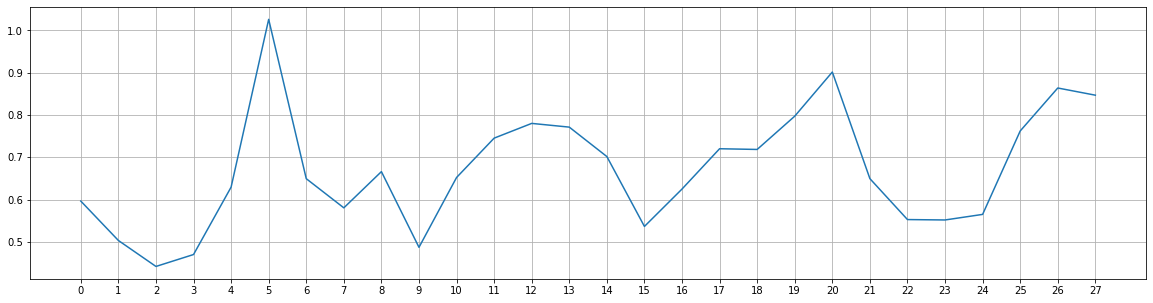

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, 28)
s = err
plt.figure(figsize=(20,5))
plt.plot(t, s)
plt.xticks(t)
plt.grid(True)

plt.show()

In [ ]:
pp = pred.copy()
for i in range(1, 28+1):
    col = f"F{i}"
    pp[col] = (pred[col] + best[col])*0.5

df = pd.concat([pp, dfeval]) 
df.to_csv(data_dir+f"submission.v{VERSION}.1.csv", index=False)


In [ ]:
# from IPython.display import FileLink, FileLinks
# FileLink(data_dir+f"submission.v{VERSION}.1.csv")

In [ ]:
worst = pd.read_csv(data_dir+'submission_v3.0.csv')
worst = worst[worst.id.str.endswith('validation')]

In [ ]:
cmp(worst, best)

4325.988056466832